In [1]:
%pylab inline

from brmp.design import RealValued, Categorical
from brmp.family import Normal, HalfNormal
from brmp.model import model_repr
from brmp.fit import marginals
from brmp.priors import Prior

from brmp.oed import SequentialOED
from brmp.oed.example import collect_plot_data, make_training_data_plot

Populating the interactive namespace from numpy and matplotlib


Note that it's also possible to run this example interactively at the command line. Run `python example.py` from `pyro/contrib/brm/oed`.

## Defining the model

Here we define the model and design space.

In [2]:
oed = SequentialOED(
    'y ~ 1 + x1 + x2',
    cols=[
        RealValued('y'),
        Categorical('x1', ['a','b']),
        Categorical('x2', ['c','d']),
    ],
    priors=[
        Prior(('b',),           Normal(0., 1.)),
        Prior(('resp','sigma'), HalfNormal(.2)),
    ]
)

The design space is assumed to be the full Cartesian product of the levels of the (assumed categorical) columns/factors appearing on the RHS of the model formula. For this model, that is:

In [3]:
oed.design_space()

[('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd')]

We have yet to collect any data:

In [4]:
assert len(oed.data_so_far) == 0
oed.data_so_far

,y,x1,x2


There are three population level coefficients in this model:

In [5]:
print(model_repr(oed.model_desc))

Population
----------------------------------------
Coef Priors:
intercept       | Normal(mu=0.0, sigma=1.0)
x1[b]           | Normal(mu=0.0, sigma=1.0)
x2[d]           | Normal(mu=0.0, sigma=1.0)
Response
----------------------------------------
Family: Normal()
Link:
  Parameter: mu
  Function:  identity
Priors:
sigma           | HalfNormal(sigma=0.2)


## A sequence of experiments

This shows the system doing something reasonable on this simple example.

### Round 1

Here we estimate the expected information gain for all designs. This currently uses a separate ANN for each design.

In [6]:
design, dstar, eigs, fit, plot_data = oed.next_trial(callback=collect_plot_data)
{'next_design': design, 'eigs': eigs}

{'next_design': ('a', 'c'),
 'eigs': [(('a', 'c'), -1.480643391609192),
  (('a', 'd'), -1.7346311807632446),
  (('b', 'c'), -1.6785697937011719),
  (('b', 'd'), -1.7985152006149292)]}

The first trial to run is `(a,c)`. Since `a` and `c` are coded as zero, this trial will isolate the effect of the intercept coefficient.

We can also look at the marginals of the samples drawn from the prior:

In [7]:
print(marginals(fit))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept  0.03  0.99 -1.92 -0.62  0.07  0.69  1.94
    b_x1[b]  0.01  1.00 -2.09 -0.64  0.01  0.71  1.89
    b_x2[d] -0.02  1.01 -2.11 -0.69 -0.05  0.67  2.02
      sigma  0.16  0.12  0.01  0.06  0.14  0.23  0.45


#### A look at what q is trained on...

For each design/coefficient pair, this plot shows the target ($\theta \in [-0.5,0.5]$) and the function learned by the corresponing ANN. (I fiddled with the priors and `eps` to make the unique shape exhibited by the `(a,c)`/coeff0 case more pronounced.)

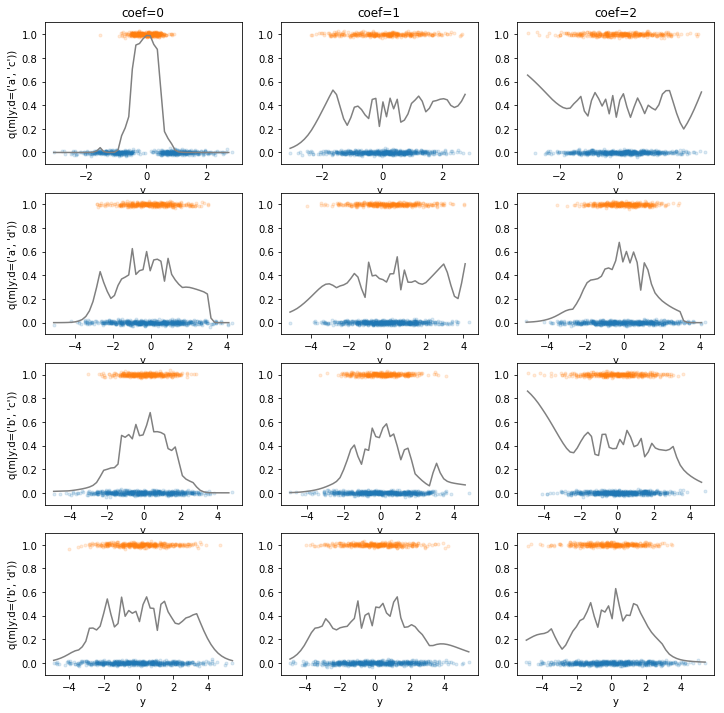

In [8]:
make_training_data_plot(plot_data)

Here we imagine running the suggested trial and extend `data_so_far` with the result. (I'm imagining that the intercept is about -3, and the other coefs are about 0.)

In [9]:
oed.add_result(design, result=-3.0)
oed.data_so_far

,y,x1,x2
0,-3.0,a,c


### Round 2

We can now compute the next trial:

In [10]:
design2, dstar2, eigs2, fit2, plot_data2 = oed.next_trial(callback=collect_plot_data)

warmup:   0%|          | 6/1500 [00:00<00:38, 38.33it/s, step size=5.97e-02, acc. prob=0.634]

sample: 100%|██████████| 1500/1500 [00:36<00:00, 40.92it/s, step size=3.06e-01, acc. prob=0.854]


We can look at the current posterior to confirm that the first trial significantly reduced our uncertainty about the intercept coef. Our beliefs about the other coefs were largely unchanged.

In [11]:
print(marginals(fit2))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept -2.83  0.30 -3.26 -3.01 -2.91 -2.70 -2.06
    b_x1[b] -0.08  1.04 -2.07 -0.78 -0.08  0.66  1.87
    b_x2[d]  0.04  1.05 -1.79 -0.64 -0.03  0.74  2.21
      sigma  0.22  0.13  0.05  0.11  0.19  0.30  0.53


The next trial selected is `(b, c)`. We see that `(a, d)` was also close to been selected. This makes sense, as each of these involves exactly one of two coefs about which we have the most uncertainty.

In [12]:
{'next_design': design2, 'eigs': eigs2}

{'next_design': ('b', 'c'),
 'eigs': [(('a', 'c'), -1.3031190633773804),
  (('a', 'd'), -1.0093016624450684),
  (('b', 'c'), -0.9859836101531982),
  (('b', 'd'), -1.1203031539916992)]}

Here's the training data seen by q again. The pairs `(a,d)`/coef2 and `(b,c)`/coef1 have the same distinctive shape as `(a,c)`/coef0 had in the first round. Also note that samples for coef0 are now mostly (or entirely) outside of `eps`.

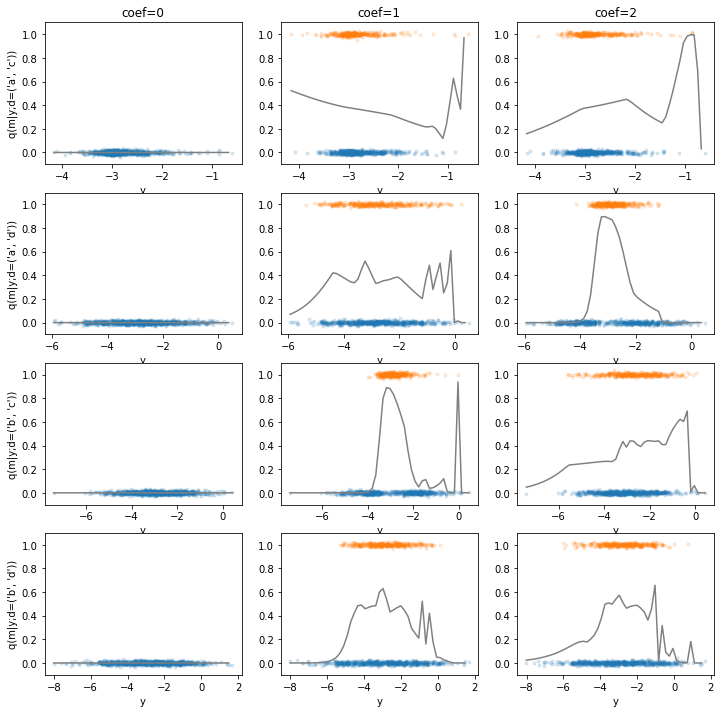

In [13]:
make_training_data_plot(plot_data2)

Run and record the suggested trial:

In [14]:
oed.add_result(design2, result=-3.1)
oed.data_so_far

,y,x1,x2
0,-3.0,a,c
0,-3.1,b,c


### Round 3

In [15]:
design3, dstar3, eigs3, fit3, plot_data3 = oed.next_trial(callback=collect_plot_data)

warmup:   0%|          | 4/1500 [00:00<00:55, 27.06it/s, step size=3.98e-02, acc. prob=0.498]

sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.26it/s, step size=2.91e-01, acc. prob=0.760]


As expected, the uncertainty about the coef isolated by the previous trial (coef1/`b_x1[b]`) was reduced:

In [16]:
print(marginals(fit3))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept -2.89  0.22 -3.24 -3.03 -2.94 -2.79 -2.37
    b_x1[b] -0.19  0.29 -0.83 -0.31 -0.15 -0.03  0.29
    b_x2[d] -0.05  1.02 -2.05 -0.72 -0.07  0.61  1.88
      sigma  0.18  0.11  0.04  0.09  0.15  0.26  0.45


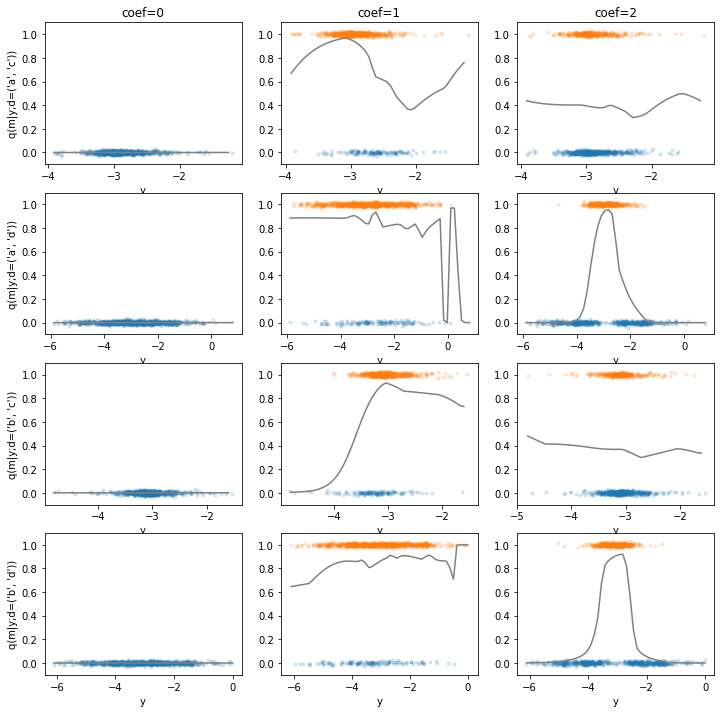

In [17]:
make_training_data_plot(plot_data3)

The proposed next trial is one of the two trials that isolates the effect of the final parameter about which there is a large amount of uncertainty. (The other such trial also has high EIG.)

In [18]:
{'next_design': design3, 'eigs': eigs3}

{'next_design': ('b', 'd'),
 'eigs': [(('a', 'c'), -0.9886300563812256),
  (('a', 'd'), -0.6980107426643372),
  (('b', 'c'), -1.0133479833602905),
  (('b', 'd'), -0.6766782402992249)]}

In [19]:
oed.add_result(design3, result=-2.95)
oed.data_so_far

,y,x1,x2
0,-3.00,a,c
0,-3.10,b,c
0,-2.95,b,d


### Round 4

In [20]:
design4, dstar4, eigs4, fit4, plot_data4 = oed.next_trial(callback=collect_plot_data)

sample: 100%|██████████| 1500/1500 [00:35<00:00, 42.19it/s, step size=2.90e-01, acc. prob=0.754] 


In [21]:
print(marginals(fit4))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept -2.86  0.25 -3.24 -3.01 -2.93 -2.74 -2.22
    b_x1[b] -0.20  0.31 -0.91 -0.37 -0.13 -0.03  0.32
    b_x2[d]  0.09  0.30 -0.68 -0.04  0.10  0.25  0.65
      sigma  0.20  0.13  0.04  0.10  0.18  0.28  0.50
